<a href="https://colab.research.google.com/github/totti0223/26_lsystem_like_panicle_generation/blob/master/panicle_simulation-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

packaged everything as a function

In [0]:
#野下さんのコードをもとに改変した穂構造記述システム
%matplotlib inline
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse, Circle

# basics

## Restrictions

In [0]:
def thresh(mean,stdev, minimum=None,maximum=None):
    import numpy as np
    '''
    returns a threshold value based on mean, stdev, etc.
    '''
    val = np.random.normal(mean,stdev,size=1000)
    val = np.random.choice(val)
    if minimum:
        val = np.maximum(val,minimum)
    if maximum:
        val = np.minimum(val,maximum)
    return val

In [3]:
# restriction rules

#High-Resolution Inflorescence Phenotyping Using a Novel Image-Analysis Pipeline, PANoramaの数値を参考にしている。

# matplot上の1単位を1 mmとする -> 35.52 mmは35.52単位
# below have only have average in the paper. else generate from random normal
EL = 35.52  # length of exsertion: point from flag leaf ligule attachment point to panicle notch. 
RL = 121 # length of main axis: point from panicle notch to inflorescence abortion point

def PBL(mean=70.11,stdev=10.17,minimum=54.46,maximum=84.36):
    #length of primary branches
    return thresh(mean,stdev,minimum=minimum,maximum=maximum)
def SBL(ratio=0.1):
    #length of secondary branches
    return PBL()*(0.2)
def PDL():
    #pedicel length
    return 5
    
def NL(mean=23.04,stdev=9.8, minimum=10.45,maximum=34.4):
    #distance between node
    return thresh(mean,stdev,minimum=minimum,maximum=maximum)

def BpN(mean=1.236,stdev=0.384, minimum=1,maximum=3):
    # BpN: number of panicle that generates per node, a normal distribution based on mean number of branches per node and stdev number of branches per node
    return np.maximum(1,int(np.round(thresh(mean,stdev,minimum=minimum,maximum=maximum))))
def get_dict():
    dicts = {'RL':RL,"EL":EL,'pbl':PBL(),'pbl_terminal':PBL()*(4/5),'sbl':SBL()}
    return dicts

#呼び出すたびに閾値が変わる。
for i in range(5):
    print(get_dict())

{'RL': 121, 'EL': 35.52, 'pbl': 72.17686048992265, 'pbl_terminal': 56.02060396943123, 'sbl': 13.040302106410227}
{'RL': 121, 'EL': 35.52, 'pbl': 67.40290392474485, 'pbl_terminal': 46.99106906028098, 'sbl': 12.670919722873156}
{'RL': 121, 'EL': 35.52, 'pbl': 74.5531777594427, 'pbl_terminal': 57.64133419795092, 'sbl': 15.779652607151034}
{'RL': 121, 'EL': 35.52, 'pbl': 79.72796062856533, 'pbl_terminal': 64.07725868160405, 'sbl': 12.975573016131486}
{'RL': 121, 'EL': 35.52, 'pbl': 82.3455207863319, 'pbl_terminal': 55.98013066619592, 'sbl': 15.412370361324001}


## l-system related functions

In [0]:
def panicle_rule(state):
    #EL(length of exsertion)をまず生成する
    if state == 0:
        new_state = [0]
    #established node
    if state == 0.1:
        new_state = [0, 0.1]
    # 1 below the ear edge
    if state == 1.1:
        new_state = [1, 1.1,]
    if state == 1:
        new_state = [1]
    
    # primary branch
    if state == 2.1:
        new_state = [2,2.1]
    if state == 2:
        new_state = [2]
    
    # secondary branch
    if state == 3.1:
        new_state = [3,3.1]
    if state ==3:
        new_state = [3]
        
    #理想は角度調整できることだけど、できないからterminal primary branchだけ別にする
    # terminal primary branch
    if state == 4.1:
        new_state = [4,4.1]
    if state == 4:
        new_state = [4] 
    
    #pedicel
    if state ==5:
        new_state == [5]
    if state == 5.1:
        new_state = [5,5.1]
    #seed
    if state == 10:
        new_state = [10]
    return new_state

def update_panicle(cells, **kwargs):
    """更新
    
    入力された状態のリストに基づき，次世代の状態のリストを返す．
    
    Args:
        cells: ある時点でのセルの状態のリスト．
    
    Returns:
        new_cells: 次世代のセルの状態のリスト．
        
    制約の導入：

    
    """
    
    #argsの展開

    ##restriction rules##############################
    if 'sbl' in kwargs.keys():
        if cells.count(3) > kwargs["sbl"]:
            if 3.1 in cells:
                idx = cells.index(3.1)
                cells[idx] = 3
    
    if 'pbl_terminal' in kwargs.keys():
        #terminal branch
        if cells.count(4) > kwargs["pbl_terminal"]:
            if 4.1 in cells:
                idx = cells.index(4.1)
                cells[idx] = 4
    #primary branch
    if 'pbl' in kwargs.keys():
        if cells.count(2) > kwargs["pbl"]:
            if 2.1 in cells:
                idx = cells.index(2.1)
                cells[idx] = 2
    if 'RL' in kwargs.keys():
        if cells.count(1) > kwargs["RL"]:
            if 1.1 in cells:
                idx = cells.index(1.1)
                cells[idx] = 1
    if 'EL' in kwargs.keys():
        if cells.count(0) > kwargs["EL"] :
            if 0.1 in cells:
                idx = cells.index(0.1)
                cells[idx] = 1.1        
    #############################################
    
    cells_tmp = []
    for cell in cells:
        cells_tmp.append(panicle_rule(cell))
    new_cells = [cell for cell_tmp in cells_tmp for cell in cell_tmp]
    
    return new_cells

In [0]:
# gen and interpret functions
# customized
# 線を生成するための関数


def gen(idx, pos, theta, r=1, lwidth=2):
    '''
    # if edge is panicle
    if idx ==2:
        height = 2
        width = 0.2
        angle = 90
        obj = Ellipse(xy=(pos[0] - height //2 , pos[1]), height=height, width=width,angle=angle,alpha=0.6,color="green")
        pos_new = pos
        else:
    '''

    # if edge is line
    pos_new = pos + r*np.array([np.cos(theta), np.sin(theta)])
    x = np.array([pos[0], pos_new[0]])
    y = np.array([pos[1], pos_new[1]])
    #obj = Line2D(x, y, color=cm.rainbow(int(0.125*(idx-1)*255)))
    #obj = Line2D(x, y, color=cm.BuGn_r(int(0.125*(idx-1)*255)))
    #obj = Line2D(x, y, color=cm.tab20(int(0.125*(idx-1)*255)))
    if idx == 0: color ="black"
    elif idx == 1: color ="brown"
    elif idx == 2 or idx == 4: color = "blue"
    elif idx ==3: color = "red"
    else: color = "green"
    
    if idx == 10:
        #draw seed
        obj = Circle(xy=(x[1],y[1]),radius=0.5,color="black")
    else:
        obj = Line2D(x, y, color=color)
    return (obj, pos_new)

# ある時点のセルの状態のリストに基づき分岐パタンを描写するための関数


def interpret(ax, cells, pos_in, theta_in, theta_shift_in, depth=0):
    """分岐パタンの描写

    入力された状態のリストに基づき，分岐パタンを描写する．

    Args:
        ax: 描写するための`axes.Axes`オブジェクト
        cells: セルの状態のリスト
        pos_in: 描写の起点となるx,y座標
        theta_in: 描写の向きを指定するx軸からの角度
        theta_shift_in: 分岐角度

    Returns:
        ax_new: 分岐パタンを追加した`axes.Axes`オブジェクト

    """
    pos = pos_in
    theta = theta_in
    ax_new = ax
    theta_shift = theta_shift_in
    for i,cell in enumerate(cells):
        if type(cell) is list:
            # 再帰的定義を利用している
            depth += 1            
            ax_new = interpret(ax, cell, pos, theta + theta_shift, theta_shift*0.5, depth=depth)
            # 右左をスイッチする　
            theta_shift = - theta_shift
        else:
            if cell ==4:
                theta = np.pi/2
            obj, pos = gen(cell, pos, theta, r=0.5, lwidth=8)
            
            if cell == 10:
                ax_new.add_patch(obj)
            else:
                ax_new.add_line(obj)
    return ax_new

## generating functions

In [0]:
def base_branch(cells):

    # get random restrictions
    pbl = PBL()

    k = 1000
    for n in range(k):
        _cells = update_panicle(cells, **get_dict())
        if cells == _cells:
            break
        else:
            cells = _cells
    return cells

def primary_branch(cells):
    k=1000
    #get position to insert secondary branch
    start = cells.index(1)
    #print(cells.count(1))
    #insert_indices = list(range(0,cells.count(1),int(NL())))
    #insert_indices = [x+start for x in insert_indices]
    #print(insert_indices)

    #50も分岐はないだろうという仮定のもと
    insert_indices = [0]
    for i in range(50):
        insert_indices.append(NL())
    insert_indices = np.array(insert_indices)
    #print(cells.count(1)//NL())
    insert_indices = np.cumsum(insert_indices)
    insert_indices = [int(x+start) for x in insert_indices if x<RL]

    if insert_indices[-1]<len(cells):
        insert_indices += [len(cells)]
    memory = 0
    for i,idx in enumerate(insert_indices):
        #determine how many branches to generate
        bpn = BpN()
        #last node and first node will be allways single 
        primarybranches = []


        if i == len(insert_indices) -1:
            #terminal branch or first primary branchの場合は１branchのみ
            bpn = 1
        elif i == 0:
            bpn = 1

        for branch in range(bpn):
            _dicts = get_dict()
            if i == len(insert_indices) -1:
                primarybranch = [4.1]
            else:
                primarybranch = [2.1]

            for n in range(k):
                _primarybranch = update_panicle(primarybranch,**_dicts)

                #制約に全部ヒットしたものは同じ値が返されるため、更新されずループ。
                if primarybranch == _primarybranch:
                    break
                else:
                    primarybranch = _primarybranch
            primarybranches.append(primarybranch)
        for t, primarybranch in enumerate(primarybranches):
            cells.insert(idx+t+memory,primarybranch)
        memory += len(primarybranches)
    return cells

def secondary_branch(cells):
    k=1000
    for i, pb in enumerate(cells):
        if type(pb) == list:
            #cells[i]がprimary branchのlist

            #secondary branchの挿入position)

            insert_indices = []
            for m in range(50):
                insert_indices.append(NL())
            insert_indices = np.array(insert_indices)
            #print(cells.count(1)//NL())
            insert_indices = np.cumsum(insert_indices)
            insert_indices = [int(x) for x in insert_indices if x<len(pb)]

            #最後にsecondaryはつけない
            #if insert_indices[-1]<len(pb):
            #    insert_indices += [len(pb)]
            memory = 0
            for t,idx in enumerate(insert_indices):
                _dicts = get_dict()
                secondarybranch = [3.1]
                for n in range(k):
                    _secondarybranch = update_panicle(secondarybranch,**_dicts)

                    #制約に全部ヒットしたものは同じ値が返されるため、更新されずループ。
                    if secondarybranch == _secondarybranch:
                        break
                    else:
                        secondarybranch = _secondarybranch
                cells[i].insert(idx+t,secondarybranch)
    return cells

def pedicel_branch(cells):
    # add pedicel in primary branch and secondary branch, respectively
    # pedicel length is fixed. not important in the current experiment
    pedicel = [5]*PDL()+[10]

    # pedicel 間の距離がわからないので、NL()の(1/2程度にしておく？)を流用する

    # 深い方からpedicelをattachしていく
    # secondary branchにpedicelをattach
    for i, pb in enumerate(cells):
        if type(pb) == list:
            for j, sb in enumerate(pb):
                if type(sb) == list:
                    # cells[i][j] to access the secondary branch
                    insert_indices = []
                    for m in range(50):
                        insert_indices.append(NL()/4)
                    insert_indices = np.array(insert_indices)
                    # print(cells.count(1)//NL())
                    insert_indices = np.cumsum(insert_indices)
                    insert_indices = [int(x)
                                      for x in insert_indices if x < len(sb)]
                    if insert_indices:
                        if insert_indices[-1] < len(sb):
                            insert_indices += [len(sb)]
                    else:
                        insert_indices += [len(sb)]

                    for t, idx in enumerate(insert_indices):
                        cells[i][j].insert(idx+t, pedicel)

    # primary branchにpedicelをattach
    for i, pb in enumerate(cells):
        if type(pb) == list:
            insert_indices = []
            for m in range(50):
                insert_indices.append(NL()/2)
            insert_indices = np.array(insert_indices)
            # print(cells.count(1)//NL())
            insert_indices = np.cumsum(insert_indices)
            insert_indices = [int(x) for x in insert_indices if x < len(pb)]
            if insert_indices[-1] < len(pb):
                insert_indices += [len(pb)]
            for t, idx in enumerate(insert_indices):
                cells[i].insert(idx+t, pedicel)
    return cells
    
def generate_panicle():
    cells = [0.1]
    cells = base_branch(cells)
    cells = primary_branch(cells)
    cells = secondary_branch(cells)
    cells = pedicel_branch(cells)
    return cells

## draw panicle

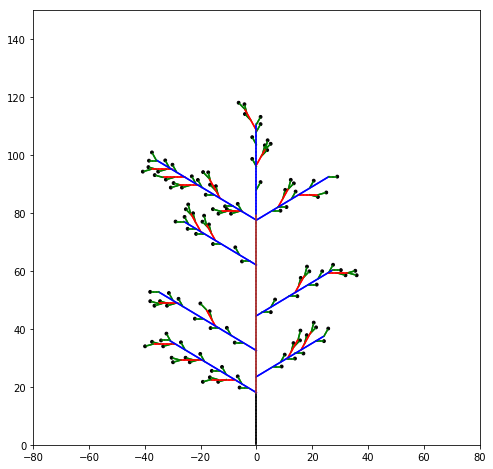

In [7]:
# 描写の実行
cells = generate_panicle()

fig, ax = plt.subplots(figsize=(8, 8))

ax = interpret(ax,cells,np.array([0,0]),np.pi/2,np.pi*(1/3))

plt.xlim([-80,80])
plt.ylim([0,150])

# プロット
plt.show()

## draw in batch

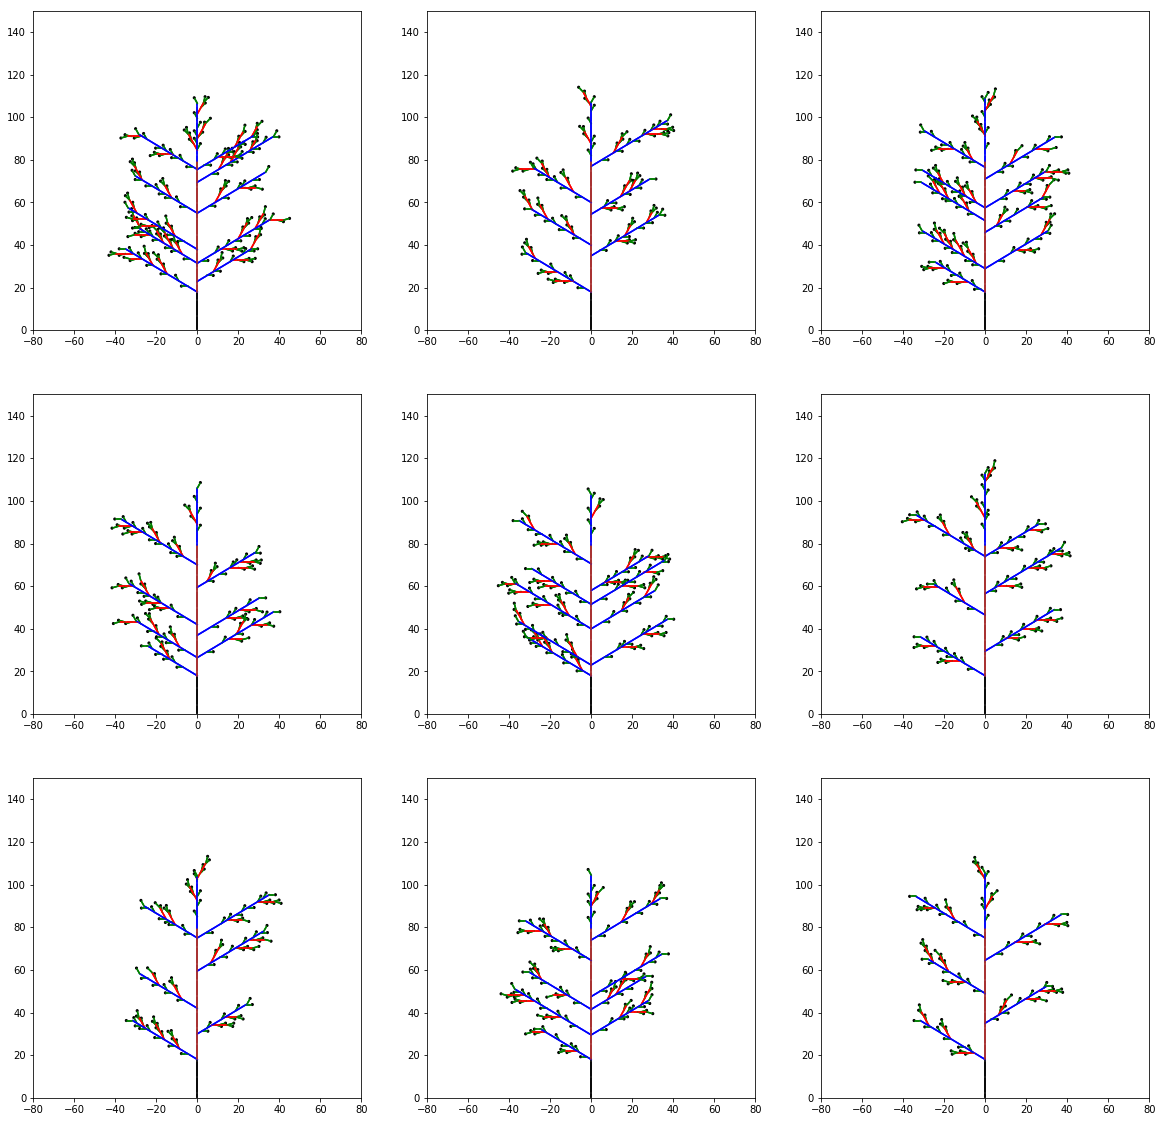

In [9]:
fig = plt.figure(figsize=(20, 20))

for i in range(9):
    cells = generate_panicle()
    ax = fig.add_subplot(3,3,i+1)
    ax = interpret(ax,cells,np.array([0,0]),np.pi/2,np.pi*(1/3))
    plt.xlim([-80,80])
    plt.ylim([0,150])